<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description-and-Dataset" data-toc-modified-id="Description-and-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description and Dataset</a></span></li><li><span><a href="#Method:-Expected-Signature" data-toc-modified-id="Method:-Expected-Signature-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Method: Expected Signature</a></span></li><li><span><a href="#Method:-Pathwise-expected-signature" data-toc-modified-id="Method:-Pathwise-expected-signature-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method: Pathwise expected signature</a></span></li><li><span><a href="#Method:-RBF-kernel-mean-embedding" data-toc-modified-id="Method:-RBF-kernel-mean-embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Method: RBF kernel mean embedding</a></span></li><li><span><a href="#Comments" data-toc-modified-id="Comments-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Comments</a></span></li></ul></div>

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import iisignature
import sys
sys.path.append("Distribution_Regression_Streams/")
from importlib import reload
import GP_models.GP_sig_precomputed as GP_sig
import GP_models.GP_sig_ARD as GP_sig_ARD
import GP_models.GP_classic as GP_classic
from data_generators import rough_volatility
import signature_features
import utils
import experiments
from fbm import FBM

# Description and Dataset

We apply different models to the problem of statistical inference for SDEs. From a set of samples from a parametrized family of stochastic processes, we want to infer the parameter.

The example considered in this notebook is the following

\begin{align*}
dP_t &= \mu P_tdt + \sigma_tdW_t && \text{(price)}  \\
d\sigma_t &= -\alpha(\sigma_t-m)dt + \nu dW^H_t && \text{(volatility)} 
\end{align*}

We observe independent copies of $\{P_t,t\in[0,T]\}$ and we want to infer $\alpha$

In [4]:
reload(rough_volatility)

t_span=np.linspace(0,10,100)

example = rough_volatility.Rough_Volatility(N_bags=5,N_items=5,t_span=t_span, hurst=0.5, spec_param={'alpha':[1,1],'m':[0.000025,0.000025],'nu':[1.,5.],'mu':[0.0003,0.0003],'Y0_1':[600,600],'Y0_2':[0.001,0.1]})

# generate data and get the labels
example.generate_data()
example.get_nu()

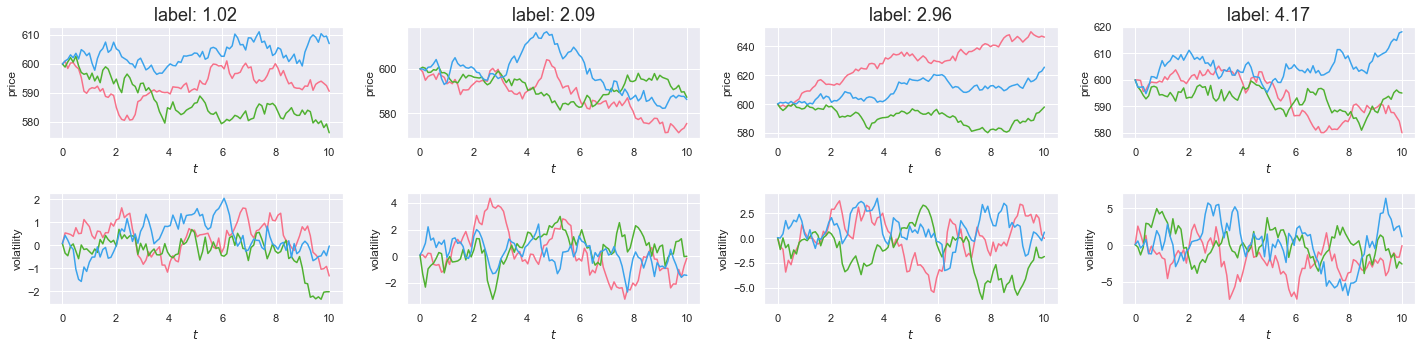

In [814]:
example.plot(N=4, N_items=3)

Choose whether to standard scale the data or not, and obtain a train/test split

In [7]:
reload(utils)#[:,:,:,None]
#example.subsample(10)
data_scaled, y_scaled, train_indices, test_indices = utils.split_standardize(example.labels,example.paths[:,:,:,0][:,:,:,None],standardized=True,method='standard')

/Users/maudlemercier/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2239: UserWarning: n_quantiles (5) is greater than the total number of samples (3). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


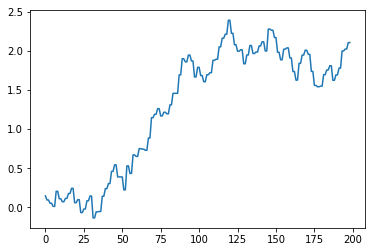

In [9]:
plt.plot(X_aug[0,0,:,0])

As the paths $y$ are one dimensional, we add 

In [8]:
X_aug = utils.add_dimension([e.copy() for e in data_scaled],add_time=False,lead_lag=0)

# Method: Expected Signature

\begin{align*}
K_1(\mu,\nu)=\exp{\Bigl(-\frac{\|\mathbb{E}_{X\sim\mu}[S(X)]-\mathbb{E}_{Y\sim\nu}[S(Y)]\|^2}{2\ell^2}\Bigr)}
\end{align*}

shape of the final features (N_bags, D): (150, 2046)


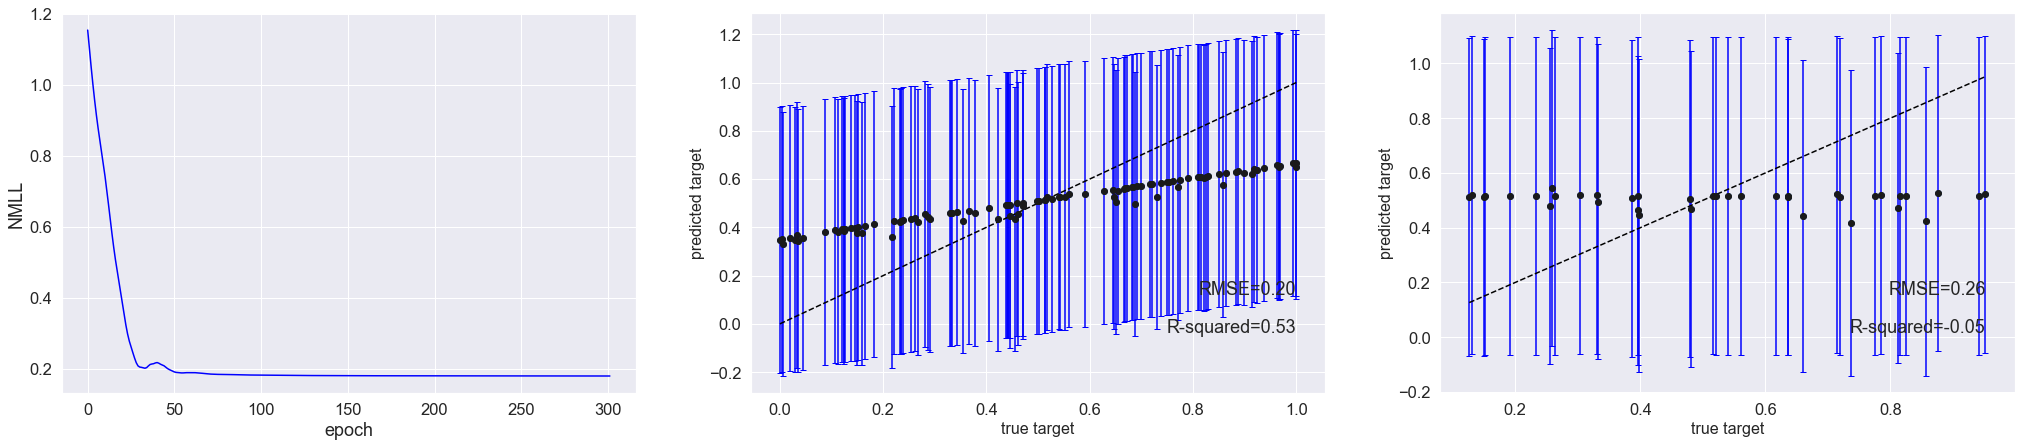

In [812]:
reload(experiments)
reload(signature_features)
reload(GP_sig)
reload(GP_sig_ARD)

sig_level = 10

# Compute the expected signature
expected_sig = signature_features.scaled_expected_sig([e.copy() for e in X_aug],sig_level)
# expected_sig,bef,aft = signature_features.scaled_expected_sig([e.copy() for e in X_aug], sig_level, M=1000,
#             a=1, ilya_rescale=True, return_norms=True)
# Standard scale the features
features = expected_sig
# var = np.var(features,axis=0)
# ## potentially scale the features
scaler = StandardScaler()
to_fit = [features[i] for i in train_indices]
scaler.fit(to_fit)
features = scaler.transform(features)

print('shape of the final features (N_bags, D):', features.shape)

# Precompute the Gram matrix, as we do not optimize any parameter
K_precomputed = experiments.precompute_K(features)

# Train and Predict
a,b,c,d= experiments.experiment_precomputed(K_precomputed,y_scaled,train_indices,test_indices,param_init=[10,0,0],RBF=True,plot=True)
     
#a,b,c,d = experiments.experiment_ARD(features,y_scaled,2,sig_level,train_indices,test_indices,param_init=[10,0,0],RBF=True,plot=True)
      

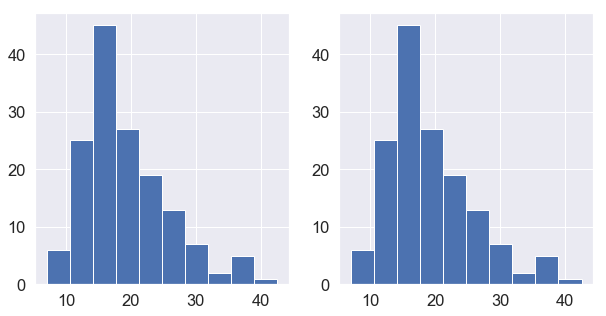

In [798]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].hist(bef)
ax[1].hist(aft)
plt.show()

# Method: Pathwise expected signature

\begin{align*}
K_2(\mu,\nu)=\langle S(\gamma^{\mu}), S(\gamma^{\nu})\rangle && \gamma^{\mu}=t\mapsto\mathbb{E}_{X\sim\mu}S(X|_{0,t})
\end{align*}

(100, 999, 14)
shape of the final features (N_bags, D): (100, 2954)


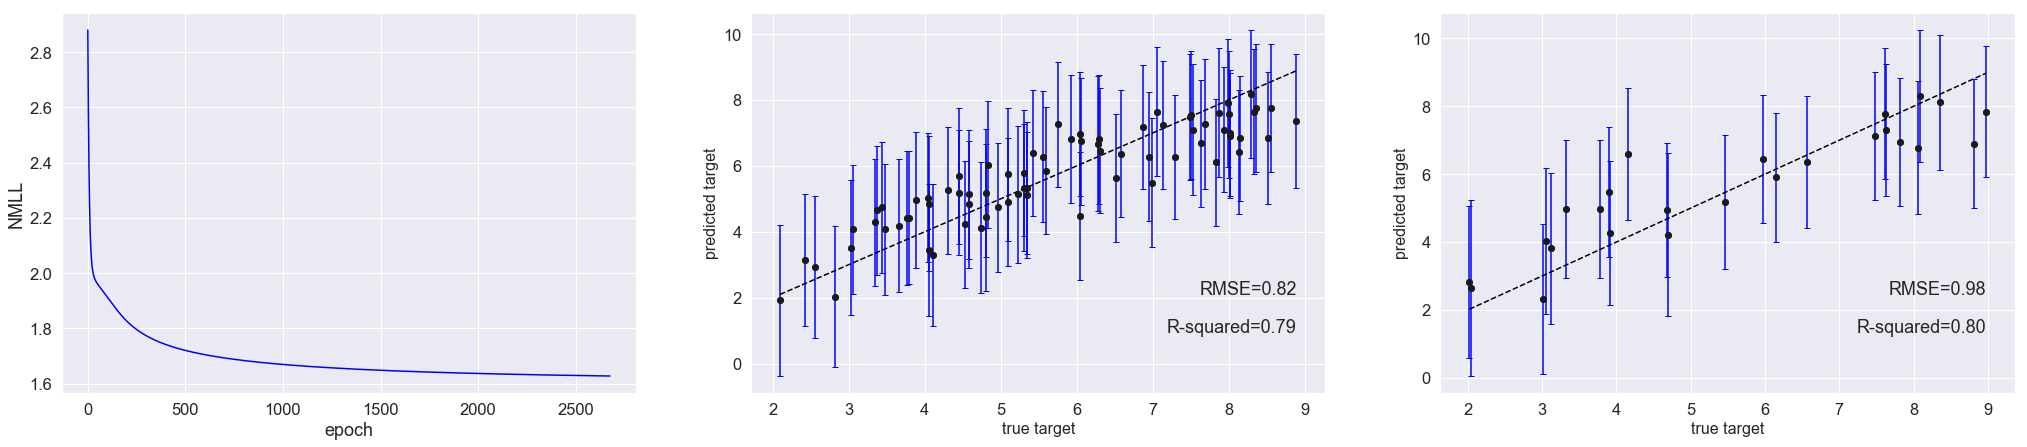

In [610]:
# specs for pathwise expected sig
reload(signature_features)
reload(experiments)
reload(GP_sig_ARD)
sig_level1 = 3

# specs for signature
sig_level2 = 3

# pathwise expected sig  
expected_pathwise_sig = signature_features.scaled_pathwise_expected_iisignature([e.copy() for e in X_aug],sig_level1)#,M=100,ilya_rescale=True)

features = expected_pathwise_sig
print(features.shape)
# potentially standard scale the features
# scaler =StandardScaler()
# print(features.shape)
# print(np.array([features[i] for i in train_indices]).shape)
# to_fit = np.array([features[i] for i in train_indices]).reshape(-1,features.shape[1])
# scaler.fit(to_fit)
# features = scaler.transform(features.reshape(-1,features.shape[1])).reshape(features.shape)

# compute the signature of the pathwise expected signature
signatures = iisignature.sig(features,sig_level2)


# potentially standard scale the features
# scaler = StandardScaler()
# to_fit = [signatures[i] for i in train_indices]
# scaler.fit(to_fit)
# signatures = scaler.transform(signatures)

print('shape of the final features (N_bags, D):', signatures.shape)
var = np.var(signatures,axis=0)
# Precompute the Gram matrix
K_precomputed = experiments.precompute_K(signatures)

# Train and Predict
a,b,c,d= experiments.experiment_precomputed(K_precomputed, y_scaled,train_indices,test_indices,plot=True)

      
#a,b,c,d = experiments.experiment_ARD(signatures,y_scaled,14,sig_level2,train_indices,test_indices,param_init=[10,0,0],RBF=False,plot=True)

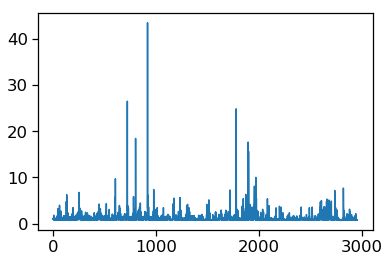

In [274]:
plt.plot(var)

# Method: RBF kernel mean embedding

\begin{align*}
K_3(\mu,\nu)=\langle\mathbb{E}_{X\sim\mu}[\Phi_{\mathrm{SE}}(X)],\mathbb{E}_{Y\sim\nu}[\Phi_{\mathrm{SE}}(Y)]\rangle
\end{align*}

In [10]:
reload(experiments)
reload(GP_classic)
import torch
# We use the same augmented path as used in the signature methods
input_ = X_aug

# but we stack dimensions of the paths
N = np.array(input_).shape[3]
input_ = np.concatenate([np.array(np.array(input_)[:,:,:,k]) for k in range(N)],axis=2)
print('shape of the input (N_bags, N_items, D):', input_.shape)

# Train and predict
#a,b,c,d=experiments.naive_experiment(input_,y_scaled ,train_indices,test_indices,param_init=[0,0,0,0],plot=True,ARD=False,device=torch.device('cpu'))



shape of the input (N_bags, N_items, D): (5, 5, 398)


In [1]:
input_.shape

NameError: name 'input_' is not defined

# Comments

* The \textit{expected signature} method with a RBF second-level kernel gives poor results in this experiment. I have not checked different hyperparameters initializations for the RBF second-level kernel. The results correspond to a linear kernel (by setting RBF=False), i.e.

\begin{align*}
K_1(\mu,\nu)=\sigma^2\langle\mathbb{E}_{X\sim\mu}[S^{\leq n}(X)],\mathbb{E}_{Y\sim\nu}[S^{\leq n}(Y)]\rangle
\end{align*}


* The \textit{pathwise expected signature} method gives the best results (in this experiment) for a truncation level equal to 1, which is equivalent to the above 

\begin{align*}
K_2(\mu,\nu)=\langle S^{\leq 1}(\gamma^{\mu}), S^{\leq 1}(\gamma^{\nu})\rangle=K_1(\mu,\nu) && \gamma^{\mu}=t\mapsto\mathbb{E}_{X\sim\mu}S^{\leq n}(X|_{0,t})
\end{align*}




In [402]:
import experiment_script_SDE as experiment_script_SDE
reload(experiment_script_SDE)
experiment_script_SDE.exp3(N_MC=10,subsampling=[1,2, 4, 7, 8, 15],device=torch.device('cpu'))

0
1
2
3
4
5
6
7
8
9


In [371]:
path = np.random.rand(5,1)

In [372]:
from addtime import AddTime, LeadLag
lead_lag_tf = LeadLag([0])
lead_lag_tf.fit_transform([path])[0]

array([[0.97939047, 0.97939047],
       [0.90267206, 0.97939047],
       [0.90267206, 0.90267206],
       [0.47731457, 0.90267206],
       [0.47731457, 0.47731457],
       [0.72352395, 0.47731457],
       [0.72352395, 0.72352395],
       [0.09398851, 0.72352395],
       [0.09398851, 0.09398851]])

In [393]:
len(np.arange(200)[::8])

25